In [29]:
%load_ext autoreload
%autoreload 2

import sys 
import pandas as pd
import sqlite3

sys.path.append("..")

import analizer as an

# pd.set_option('max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Load data

data_source = 'db'
data_source = 'file'

user_id = '1483383788'
files_list = ['20230717T192633_yudintut_42a8e4d5b845465ca0a4a139136a1f02.xls', 
              '20230717T192639_yudintut_c30ec7287fa54ee28d1322689db1743b.xls']
# files_list = ['full.xls'] 

if data_source == 'db':
    # Load data from sqlite
    conn = sqlite3.connect('db.sqlite')
    df_full = pd.read_sql(f'SELECT * FROM Trans WHERE USER_ID = :user_id', conn,
                        params={'user_id': user_id})
else:
    df_full = None
    # load data from xls* file
    for f in files_list:
        if not df_full is None:
            df_full = pd.concat([df_full, pd.read_excel(f)])
        else:
            df_full = pd.read_excel(f)

    df_full = an.prepare_columns(df_full)
    df_full.to_csv('merged.csv')


df_full = df_full.reset_index(drop=True)
df_full

,ORDER_ID,OPEN_DT,SIDE,QTY,SYMBOL,OPEN_PRICE,STOP_LOSS,TAKE_PROFIT,CLOSE_DT,CLOSE_PRICE,FEE,SWAP,PROFIT,COMMENT
0,133644506,2023-02-26 22:02:32,balance,0.00,NaN,0.00,0,0.00,2023-02-26 22:02:32,0.00,0,0.0,990.00,Transfer from 21429124 19876318
1,133780686,2023-02-27 20:03:08,balance,0.00,NaN,0.00,0,0.00,2023-02-27 20:03:08,0.00,0,0.0,201980.19,Deposit CCTB 19893539
2,133795448,2023-02-28 01:28:08,buy,0.04,XAUUSD,1817.41,0,1818.01,2023-02-28 03:31:06,1818.02,0,0.0,2.44,Start BUY[tp]
3,133799910,2023-02-28 03:05:00,buy,0.04,XAUUSD,1815.61,0,1818.01,2023-02-28 03:31:06,1818.02,0,0.0,9.64,BUY 2[tp]
4,133800896,2023-02-28 03:32:00,sell,0.04,XAUUSD,1817.72,0,1816.22,2023-02-28 05:31:53,1816.21,0,0.0,6.04,Start SELL[tp]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6525,149772317,2023-07-17 17:04:00,buy,0.07,XAUUSD,1951.17,0,1952.67,2023-07-17 17:11:51,1952.69,0,0.0,10.64,Start BUY[tp]
6526,149774791,2023-07-17 17:12:00,buy,0.07,XAUUSD,1952.86,0,1954.36,2023-07-17 18:00:07,1954.36,0,0.0,10.50,Start BUY[tp]
6527,149783436,2023-07-17 18:01:00,buy,0.07,XAUUSD,1953.55,0,1955.05,2023-07-17 18:59:28,1955.07,0,0.0,10.64,Start BUY[tp]
6528,149788551,2023-07-17 19:00:00,buy,0.07,XAUUSD,1954.79,0,1955.22,2023-07-17 20:59:59,1955.22,0,0.0,3.01,Start BUY[tp]


In [31]:
df_full = an.df_columns_cast(df_full)
df_full = an.delete_canceled_trans_from_df(df_full)
df_full = an.calc_balance(df_full)

df_full.shape

(6524, 22)

In [32]:
df_orders = an.extend_with_grid_details(df_full)
df_orders = df_orders.sort_values(by='OPEN_DT', ascending=False)

df_grids = an.get_grids(df_orders)

# df_full = df_full[df_full['OPEN_DT'].dt.date >= datetime.date(2023, 6, 19)]
# df_orders = df_orders[df_orders['OPEN_DT'].dt.date >= datetime.date(2023, 6, 19)]
# df_grids = df_grids[df_grids['OPEN_DT'].dt.date >= datetime.date(2023, 6, 19)]


df_sum = an.get_summary(df_full=df_full,
                        df_orders=df_orders,
                        df_grids=df_grids)


# 01. Account Summary

Период: 2023-02-26 - 2023-07-17
Календарных дней: 142
Торговых дней: 107

Пополнения: $21,291.31
Переводы: $9.90
Снятия: $-31,415.85
Прочие движения: $354.30

Баланс: $3,279.30
Собственных средств: $0.00

Прибыль: $13,049.73
Средняя прибыль в календарный день: $91.90
Средняя прибыль в торговый день: $121.96

ROE: 397.9%
ROE календарных дней: 36

ROI: 0.0%
ROI календарных дней: 0

Ордеров: 6,524
Прибыльных: 4,550
Win Rate: 69.7%
Прибыль ордера: AVG=$2.00 | MAX=$2,460.70
Убыток ордера: MAX=$-525.01

Cеток однонаправленных: 2,956
Лот на $1000 депозита: MIN=0.0022 | AVG=0.0250 | MAX=0.6355 | LAST=0.0213
Ордеров в сетке: AVG=2.2 | MAX=17
Длительность сетки: MIN=0 days 00:00:00 | AVG=0 days 01:04:18.680311231 | MAX=3 days 05:41:00
Прибыль сетки: AVG=$4.54 | MAX=$1,860.38
Просадка сетки: AVG=-$16.47 | MAX=-$7,785.40
Просадка сетки от депозита: AVG=0.1% | MAX=37.6%


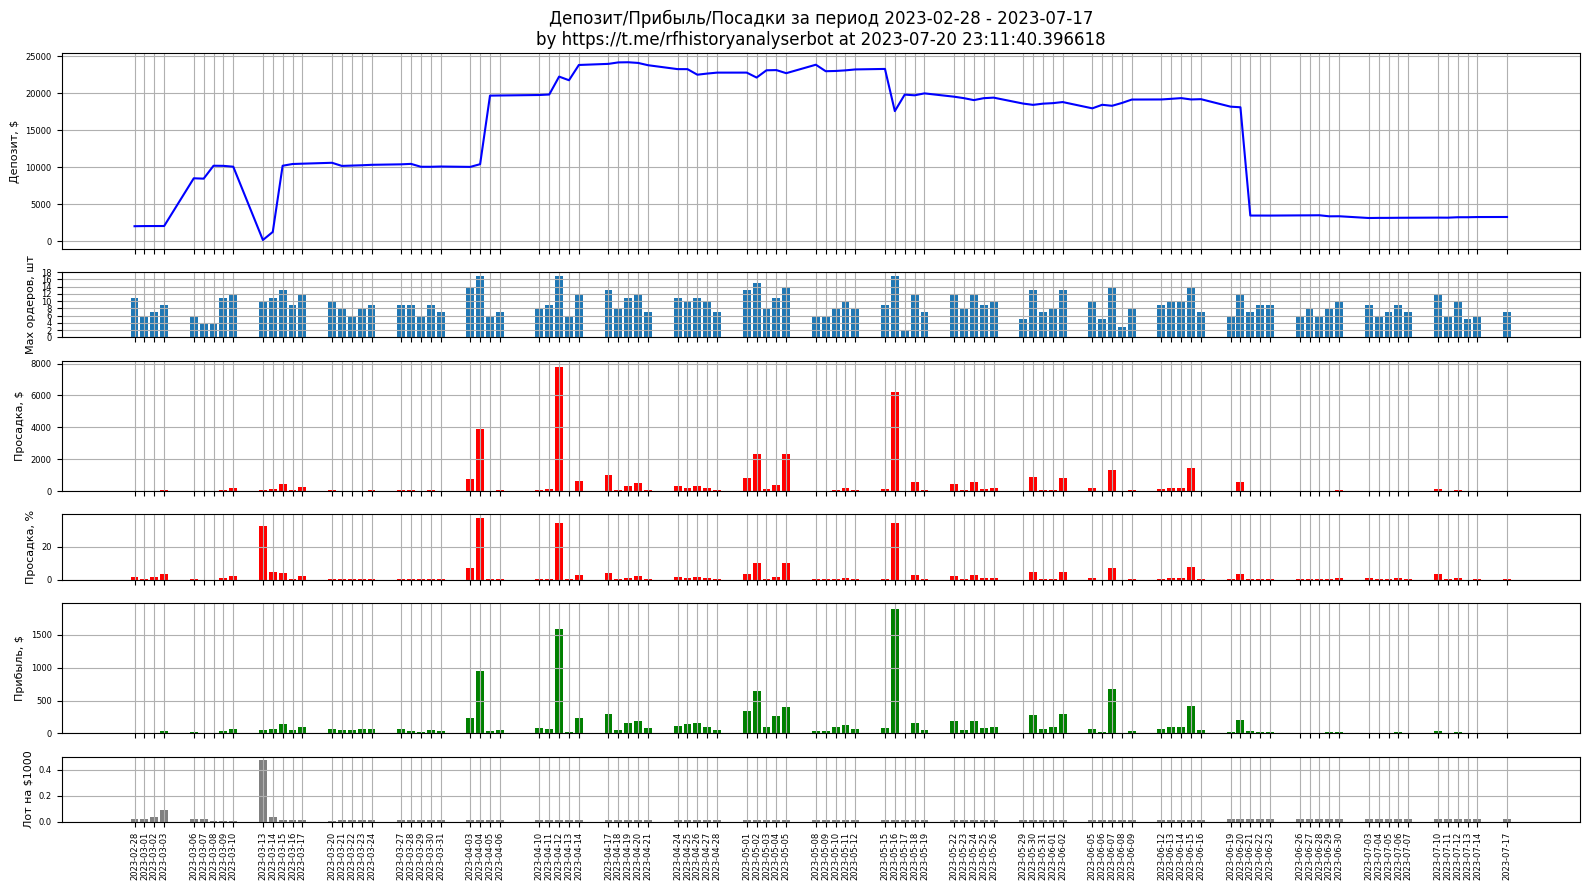

In [34]:
print(f"Период: {df_sum.iloc[0]['START_DATE']} - {df_sum.iloc[0]['FINISH_DATE']}")
print(f"Календарных дней: {df_sum.iloc[0]['CAL_DAYS']:,.0f}")
print(f"Торговых дней: {df_sum.iloc[0]['DAYS']:,.0f}")
print('')

print(f"Пополнения: ${df_sum.iloc[0]['DK_DEPOSIT']:,.2f}") 
print(f"Переводы: ${df_sum.iloc[0]['DK_TRANSFER']:,.2f}") 
print(f"Снятия: ${df_sum.iloc[0]['DK_WITHDRAWAL']:,.2f}")
print(f"Прочие движения: ${df_sum.iloc[0]['DK_MISC_TRANS']:,.2f}")
print(f"Прибыль: ${df_sum.iloc[0]['PROFIT']:,.2f}")
print('')

print(f"Баланс: ${df_sum.iloc[0]['BALANCE']:,.2f}")
print(f"Собственных средств: ${df_sum.iloc[0]['OWN_FUNDS']:,.2f}")
print('')

print(f"Средняя прибыль в календарный день: ${df_sum.iloc[0]['PROFIT_PER_CAL_DAY']:,.2f}")
print(f"Средняя прибыль в торговый день: ${df_sum.iloc[0]['PROFIT_PER_DAY']:,.2f}")
print('')

print(f"ROE: {df_sum.iloc[0]['ROE']*100:,.1f}%")
print(f"ROE календарных дней: {df_sum.iloc[0]['ROE_DAYS']:,.0f}")
print('')

print(f"ROI: {df_sum.iloc[0]['ROI']*100:,.1f}%")
print(f"ROI календарных дней: {df_sum.iloc[0]['ROI_DAYS']:,.0f}")
print('')

print(f"Ордеров: {df_sum.iloc[0]['ORDER_ID']:,.0f}")
print(f"Прибыльных: {df_sum.iloc[0]['HAS_ORDER_PROFIT']:,.0f}")
print(f"Win Rate: {df_sum.iloc[0]['WIN_RATE']*100:,.1f}%")
print(f"Прибыль ордера: AVG=${df_sum.iloc[0]['AVG_ORDER_PROFIT']:,.2f} | MAX=${df_sum.iloc[0]['MAX_ORDER_PROFIT']:,.2f}")
print(f"Убыток ордера: MAX=${df_sum.iloc[0]['MAX_ORDER_LOSS']:,.2f}")
print('')

print(f"Cеток однонаправленных: {df_sum.iloc[0]['GRID_CNT']:,.0f}")
print(f"Лот на $1000 депозита: MIN={df_sum.iloc[0]['MIN_LOT_1000']:,.4f} | AVG={df_sum.iloc[0]['AVG_LOT_1000']:,.4f} | MAX={df_sum.iloc[0]['MAX_LOT_1000']:,.4f} | LAST={df_sum.iloc[0]['LAST_LOT_1000']:,.4f}")
print(f"Ордеров в сетке: AVG={df_sum.iloc[0]['AVG_GRID_ORDER_CNT']:,.1f} | MAX={df_sum.iloc[0]['MAX_GRID_ORDER_CNT']:,.0f}")
print(f"Длительность сетки: MIN={df_sum.iloc[0]['MIN_GRID_DURATION']} | AVG={df_sum.iloc[0]['AVG_GRID_DURATION']} | MAX={df_sum.iloc[0]['MAX_GRID_DURATION']}")
print(f"Прибыль сетки: AVG=${df_sum.iloc[0]['AVG_GRID_PROFIT']:,.2f} | MAX=${df_sum.iloc[0]['MAX_GRID_PROFIT']:,.2f}")
print(f"Просадка сетки: AVG=-${df_sum.iloc[0]['AVG_GRID_DRAWDOWN']:,.2f} | MAX=-${df_sum.iloc[0]['MAX_GRID_DRAWDOWN']:,.2f}")
print(f"Просадка сетки от депозита: AVG={df_sum.iloc[0]['AVG_GRID_DRAWDOWN_RATIO']*100:,.1f}% | MAX={df_sum.iloc[0]['MAX_GRID_DRAWDOWN_RATIO']*100:,.1f}%")

import datetime
fig = an.get_summary_chart(df_grids)


# 03. TOP-5 biggest grid drawdowns 

In [16]:
df_grids.sort_values(by=['DK_DRAWDOWN_RATIO'], ascending=False).head(5)

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,...,DK_BALANCE_IN,DK_DURATION_TD,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_EQUITY,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_EQUITY_20,DK_LOT_1000
354,72718771,2023-06-15 15:29:02,2023-06-15 17:55:07,14,195.8928,0.15,130.83,1926.29,1958.57,255735.6654,...,10501.7552,0 days 02:00:59,1954.717308,738.2334,9763.5218,0.070296,12139.711409,1.155970,-1637.956209,0.014283
196,71462744,2023-06-07 16:54:00,2023-06-07 20:52:00,14,90.4457,0.07,58.57,1968.93,1941.51,113915.4736,...,5246.0257,0 days 02:46:02,1944.945767,306.0732,4939.9525,0.058344,5007.823306,0.954594,238.202394,0.013343
29,70146186,2023-05-30 08:54:02,2023-05-30 16:00:20,13,24.0149,0.03,15.69,1932.26,1959.51,30691.3751,...,2077.3757,0 days 06:06:20,1956.110586,81.4219,1995.9538,0.039195,2383.874548,1.147541,-306.498848,0.014441
132,70923675,2023-06-02 17:41:00,2023-06-05 12:41:38,13,24.7406,0.03,15.69,1966.89,1939.90,30488.2300,...,2123.8088,2 days 17:04:02,1943.163161,79.2841,2044.5247,0.037331,2279.338748,1.073232,-155.529948,0.014126
209,71560632,2023-06-07 22:58:01,2023-06-08 20:12:32,13,64.1212,0.08,42.71,1940.43,1969.08,83941.0089,...,6329.0320,0 days 18:32:10,1965.371316,234.8488,6094.1832,0.037107,6502.391986,1.027391,-173.359986,0.012640


# 04. Worst Market Model: TOP-5 potential drawdowns of biggest (>=13 orders) grids

Модель предполагает, что реальные сетки размером >13 ордеров не закрылись, а продолжили рост до 20 ордеров. При этом цена каждый раз двигалась бы в худшем направлении против нас.

Показаны TOP-5 сеток достроенных до 20 ордеров с их _потенциальными просадками_.

Смотри колонки:
- DK_DRAWDOWN_20 - какая будет просадка в USD
- DK_DRAWDOWN_20_RATIO - % просадки от начального депозита сетки.
- DK_EQUITY_20 - свободные средства от депозита (<0 - сумму нужно доливать)

In [17]:
df_grids[df_grids['ORDER_ID'] >= 13].sort_values(by=['DK_DRAWDOWN_20_RATIO'], ascending=False).head(5)

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,...,DK_BALANCE_IN,DK_DURATION_TD,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_EQUITY,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_EQUITY_20,DK_LOT_1000
354,72718771,2023-06-15 15:29:02,2023-06-15 17:55:07,14,195.8928,0.15,130.83,1926.29,1958.57,255735.6654,...,10501.7552,0 days 02:00:59,1954.717308,738.2334,9763.5218,0.070296,12139.711409,1.155970,-1637.956209,0.014283
29,70146186,2023-05-30 08:54:02,2023-05-30 16:00:20,13,24.0149,0.03,15.69,1932.26,1959.51,30691.3751,...,2077.3757,0 days 06:06:20,1956.110586,81.4219,1995.9538,0.039195,2383.874548,1.147541,-306.498848,0.014441
132,70923675,2023-06-02 17:41:00,2023-06-05 12:41:38,13,24.7406,0.03,15.69,1966.89,1939.90,30488.2300,...,2123.8088,2 days 17:04:02,1943.163161,79.2841,2044.5247,0.037331,2279.338748,1.073232,-155.529948,0.014126
209,71560632,2023-06-07 22:58:01,2023-06-08 20:12:32,13,64.1212,0.08,42.71,1940.43,1969.08,83941.0089,...,6329.0320,0 days 18:32:10,1965.371316,234.8488,6094.1832,0.037107,6502.391986,1.027391,-173.359986,0.012640
196,71462744,2023-06-07 16:54:00,2023-06-07 20:52:00,14,90.4457,0.07,58.57,1968.93,1941.51,113915.4736,...,5246.0257,0 days 02:46:02,1944.945767,306.0732,4939.9525,0.058344,5007.823306,0.954594,238.202394,0.013343


# 06. Worst Market Model: TOP-5 potential drawdowns of all grids (incl. small)


Модель такая же как и выше. Только до 20 ордера достроены все сетки, включая малые (1, 2, 3... ордера).

_Потенциальные просадки_ малых сеток больше, чем у больших, потому что цена двигалась бы в худшем направлении гораздо больше раз.

По этим сетка можно оценить самый апокалиптический сценарий.

In [18]:
df_grids.sort_values(by=['DK_EQUITY_20'], ascending=True).head(5)

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,...,DK_BALANCE_IN,DK_DURATION_TD,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_EQUITY,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_EQUITY_20,DK_LOT_1000
372,72858693,2023-06-16 07:50:00,2023-06-16 16:00:05,7,7.8639,0.2,5.24,1955.09,1966.96,10291.0495,...,13004.6950,0 days 07:25:00,1963.940744,25.2005,12979.4945,0.001938,15998.671998,1.230223,-2993.976998,0.015379
379,72919383,2023-06-16 15:16:01,2023-06-16 16:43:06,6,5.0588,0.2,3.26,1967.44,1957.20,6390.6374,...,13015.0757,0 days 01:17:00,1960.318221,16.0008,12999.0749,0.001229,16004.752495,1.229709,-2989.676795,0.015367
407,73141080,2023-06-20 04:55:00,2023-06-20 13:25:53,6,4.9668,0.2,3.26,1945.26,1955.71,6365.4224,...,13048.1606,0 days 05:41:11,1952.583558,16.0276,13032.1330,0.001228,16025.110095,1.228151,-2976.949495,0.015328
398,73061176,2023-06-19 11:24:02,2023-06-19 16:31:04,6,4.8829,0.2,3.26,1958.66,1948.58,6361.2777,...,13037.9823,0 days 03:36:58,1951.312178,14.7423,13023.2400,0.001131,16006.010995,1.227645,-2968.028695,0.015340
457,73500770,2023-06-21 21:33:01,2023-06-22 15:30:38,7,7.9500,0.2,5.24,1937.59,1924.90,10103.6256,...,13176.1802,0 days 17:39:00,1928.172824,26.5292,13149.6510,0.002013,15965.701498,1.211709,-2789.521298,0.015179


/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_55149/2010260726.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


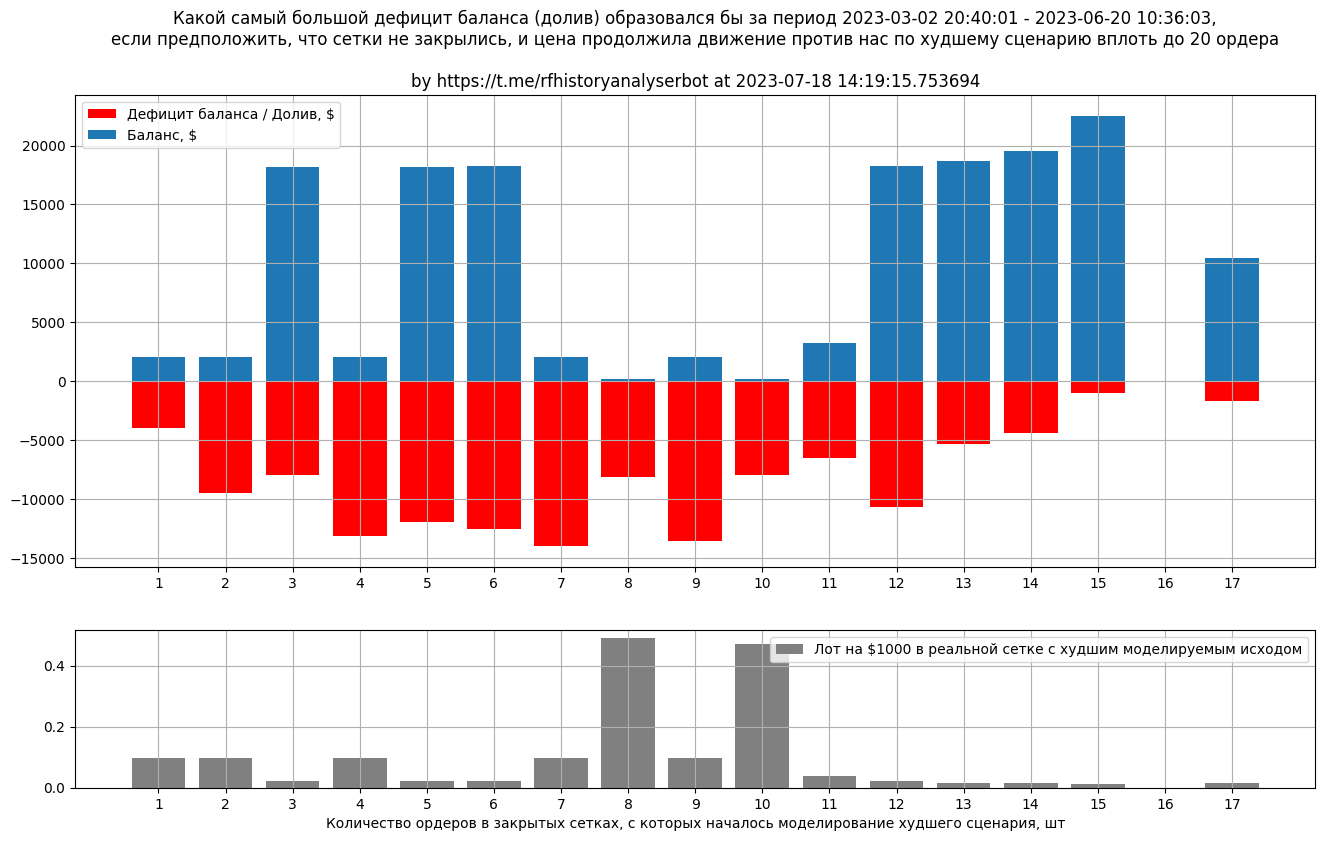

In [32]:
fig = an.get_worst_equity_20_chart(df_grids=df_grids)
fig.show()

# 07.1. Order price distance of grid

In [20]:
df_pd = df_orders.copy()

df_pd = an.get_new_order_params(df_pd)
df_pd = df_pd[['DK_GRID_ORDER_NUM', 'DK_OPEN_PRICE_DELTA_MIN', 'DK_OPEN_PRICE_DELTA_MEAN', 'DK_OPEN_PRICE_DELTA_MAX']]
df_pd[['DK_OPEN_PRICE_DELTA_MIN', 'DK_OPEN_PRICE_DELTA_MEAN', 'DK_OPEN_PRICE_DELTA_MAX']] = df_pd[['DK_OPEN_PRICE_DELTA_MIN', 'DK_OPEN_PRICE_DELTA_MEAN', 'DK_OPEN_PRICE_DELTA_MAX']].applymap('{0:.2f}'.format)
df_pd


,DK_GRID_ORDER_NUM,DK_OPEN_PRICE_DELTA_MIN,DK_OPEN_PRICE_DELTA_MEAN,DK_OPEN_PRICE_DELTA_MAX
0,1->2,1.62,2.11,4.14
1,2->3,1.58,2.19,7.87
2,3->4,1.61,2.20,4.84
3,4->5,1.67,2.27,6.59
4,5->6,1.75,2.29,4.17
5,6->7,1.80,2.28,3.96
6,7->8,1.69,2.15,3.68
7,8->9,1.79,2.22,3.77
8,9->10,1.42,2.30,3.26
9,10->11,1.95,2.50,3.13


# 07.2. Order quantity factor of grid

In [21]:
df_pd = df_orders.copy()

df_pd = an.get_new_order_params(df_pd)
df_pd = df_pd[['DK_GRID_ORDER_NUM', 'DK_QTY_FACTOR_DOC', 'DK_QTY_FACTOR_MEAN', 'DK_QTY_FACTOR_MAX']]
df_pd[['DK_QTY_FACTOR_DOC', 'DK_QTY_FACTOR_MEAN', 'DK_QTY_FACTOR_MAX']] = df_pd[['DK_QTY_FACTOR_DOC', 'DK_QTY_FACTOR_MEAN', 'DK_QTY_FACTOR_MAX']].applymap('{0:.2f}'.format)
df_pd


,DK_GRID_ORDER_NUM,DK_QTY_FACTOR_DOC,DK_QTY_FACTOR_MEAN,DK_QTY_FACTOR_MAX
0,1->2,1.10,1.07,1.20
1,2->3,1.50,1.56,1.67
2,3->4,1.51,1.55,1.60
3,4->5,1.56,1.54,1.57
4,5->6,1.58,1.58,1.59
5,6->7,1.61,1.62,1.63
6,7->8,1.65,1.65,1.65
7,8->9,1.65,1.65,1.65
8,9->10,1.65,1.65,1.65
9,10->11,1.65,1.65,1.65


# 07.3. Order time distance of grid

IMPORATANT: Distances more then 1 day are ignored as over weekend delta.

In [22]:
df_pd = df_orders.copy()

df_pd = an.get_new_order_params(df_pd)
df_pd
df_pd = df_pd[['DK_GRID_ORDER_NUM', 'DK_DURATION_TD_MIN_NO_EXTRADAY', 'DK_DURATION_TD_MEAN_NO_EXTRADAY', 'DK_DURATION_TD_MAX_NO_EXTRADAY']]
# df_pd[['DK_QTY_FACTOR_DOC', 'DK_QTY_FACTOR_MEAN', 'DK_QTY_FACTOR_MAX']] = df_pd[['DK_QTY_FACTOR_DOC', 'DK_QTY_FACTOR_MEAN', 'DK_QTY_FACTOR_MAX']].applymap('{0:.2f}'.format)
df_pd


,DK_GRID_ORDER_NUM,DK_DURATION_TD_MIN_NO_EXTRADAY,DK_DURATION_TD_MEAN_NO_EXTRADAY,DK_DURATION_TD_MAX_NO_EXTRADAY
0,1->2,0 days 00:00:59,0 days 00:30:53.540425531,0 days 03:39:00
1,2->3,0 days 00:01:00,0 days 00:34:52.635658914,0 days 04:21:01
2,3->4,0 days 00:02:00,0 days 01:10:03.593023255,0 days 08:41:00
3,4->5,0 days 00:01:04,0 days 00:50:53.907407407,0 days 09:16:00
4,5->6,0 days 00:02:00,0 days 00:59:36.243243243,0 days 04:34:59
5,6->7,0 days 00:00:45,0 days 00:47:22.956521739,0 days 04:02:59
6,7->8,0 days 00:01:00,0 days 00:23:00.933333333,0 days 02:10:02
7,8->9,0 days 00:01:09,0 days 01:15:54.750000,0 days 10:15:00
8,9->10,0 days 00:05:01,0 days 01:26:56.500000,0 days 04:15:51
9,10->11,0 days 00:07:29,0 days 00:56:03.571428571,0 days 04:39:00


In [ ]:
import pandas as pd
import sqlite3

def load_df_from_file(filename: str) -> pd.DataFrame:
    df = pd.read_excel(filename)
    df = an.prepare_columns(df)
    return df


def save_df_to_db(df: pd.DataFrame, user_id: str, conn: sqlite3.Connection):
    df['USER_ID'] = user_id
    df = df.set_index(['USER_ID', 'ORDER_ID'])

    df.to_sql(name='Trans', con=cnx, if_exists='replace')


cnx = sqlite3.connect('db.sqlite')
df = load_df_from_file('report.xls')
save_df_to_db(df=df, user_id='Denis', conn=cnx)

/Users/sournk/dev/rf-history/research/../analizer/__init__.py:210: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_res.loc[(df_res['SIDE'] == TYPE_FOR_BALANCE) & (df_res['PROFIT'] > 0) & (df_res['COMMENT'].str.contains(COMMENT_PATTERN_FOR_DEPOSIT)), ['DK_DEPOSIT']] = df_res['PROFIT']


In [ ]:
# Save data from file to sqlite

def load_df_from_db(user_id: str, conn: sqlite3.Connection) -> pd.DataFrame:
    df = pd.read_sql('SELECT * FROM Trans WHERE USER_ID = :user_id', conn, 
                     params={'user_id': user_id})
    return df

load_df_from_db(user_id='Denis',conn=cnx)



,USER_ID,ORDER_ID,OPEN_DT,SIDE,QTY,SYMBOL,OPEN_PRICE,STOP_LOSS,TAKE_PROFIT,CLOSE_DT,...,SWAP,PROFIT,COMMENT,DK_TRANS,DK_MISC_TRANS,DK_DEPOSIT,DK_WITHDRAWAL,DK_OPEN_VALUE,DK_BALANCE_OUT,DK_BALANCE_IN
0,Denis,69906476,2023-05-26 15:28:10,balance,0.00,None,0.00,0,0.00,2023-05-26 15:28:10,...,0.0,0.0000,Deposit CCTT 21364338,99.0000,0.0,99.0000,0,0.0000,99.0000,0.0000
1,Denis,69912876,2023-05-26 15:36:59,balance,0.00,None,0.00,0,0.00,2023-05-26 15:36:59,...,0.0,0.0000,Deposit CCTT 21364558,1974.0619,0.0,1974.0619,0,0.0000,2073.0619,99.0000
2,Denis,69939230,2023-05-26 17:10:33,sell,0.03,XAUUSD,1950.73,0,1949.23,2023-05-26 17:20:48,...,0.0,0.0459,Start SELL[tp],0.0459,0.0,0.0000,0,58.5219,2073.1078,2073.0619
3,Denis,69940374,2023-05-26 17:21:00,buy,0.03,XAUUSD,1949.23,0,1950.73,2023-05-26 17:27:21,...,0.0,0.0456,Start BUY[tp],0.0456,0.0,0.0000,0,58.4769,2073.1534,2073.1078
4,Denis,69940734,2023-05-26 17:28:00,sell,0.03,XAUUSD,1950.20,0,1948.70,2023-05-26 17:29:24,...,0.0,0.0468,Start SELL[tp],0.0468,0.0,0.0000,0,58.5060,2073.2002,2073.1534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,Denis,73866111,2023-06-23 17:51:01,sell,0.23,XAUUSD,1926.28,0,1923.88,2023-06-23 18:09:39,...,0.0,0.5704,SELL 2[tp],0.5704,0.0,0.0000,0,443.0444,14241.2892,14240.7188
1107,Denis,73870359,2023-06-23 18:10:00,sell,0.21,XAUUSD,1923.61,0,1922.11,2023-06-23 18:28:03,...,0.0,0.3171,Start SELL[tp],0.3171,0.0,0.0000,0,403.9581,14241.6063,14241.2892
1108,Denis,73873989,2023-06-23 18:29:00,sell,0.21,XAUUSD,1922.05,0,1920.55,2023-06-23 19:05:49,...,0.0,0.3150,Start SELL[tp],0.3150,0.0,0.0000,0,403.6305,14241.9213,14241.6063
1109,Denis,73879633,2023-06-23 19:06:00,sell,0.21,XAUUSD,1920.06,0,1919.55,2023-06-23 19:42:51,...,0.0,0.1260,Start SELL[tp],0.1260,0.0,0.0000,0,403.2126,14242.0473,14241.9213


In [ ]:
import datetime


def get_start_of_month(anyday: datetime.datetime) -> datetime.datetime:
    return anyday.replace(day=1)


def get_finish_of_month(anyday: datetime.datetime) -> datetime.datetime:
    next_month = anyday.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)


last_date_df = df_full['OPEN_DT'].dt.date.max()
print(last_date_df)
print(get_start_of_month(last_date_df))
print(get_finish_of_month(last_date_df))

print(datetime)

2023-06-27
2023-06-01
2023-06-30


TypeError: function missing required argument 'year' (pos 1)

In [ ]:
max_date = datetime.date(2022, 6, 22)

(datetime.date.today() - max_date).days



371

# Average Balance

In [55]:
# Calc AVG day balance

df_new = df_grids.copy()
df_new = df_new.sort_values('OPEN_DT')
df_new['DK_DAY'] = df_new['OPEN_DT'].dt.date
df_new = df_new.groupby('DK_DAY').agg({
    'DK_BALANCE_IN': ['first', 'mean'],
    'PROFIT': 'sum'

})

df_new.columns = df_new.columns.to_flat_index()
df_new.columns = ['_'.join(col) for col in df_new.columns.values]

df_new['RO*'] = df_new['PROFIT_sum'] / df_new['DK_BALANCE_IN_first'] * 100

df_new


df_new['PROFIT_sum'].mean() / df_new['DK_BALANCE_IN_first'].mean() * 100
df_new['DK_BALANCE_IN_first'].mean()



10755.46013030303

In [53]:
df_orders['DK_BALANCE_IN'].mean()

10626.638814505226

In [63]:
df_o2 = df_orders.copy()
df_o2 = df_o2.sort_values('OPEN_DT')
df_o2['DK_DAY'] = df_o2['OPEN_DT'].dt.date
df_o2.groupby('DK_DAY').agg({
    'DK_BALANCE_IN': 'first'
})['DK_BALANCE_IN'].mean()

10755.610321212123